In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

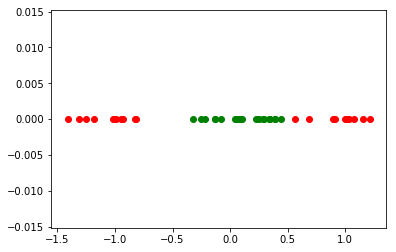

In [382]:

random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 20
X = rand_clusters(1,n//2,.5,-1,-1)
X += rand_clusters(1,n//2,.5,1,1)
X += rand_clusters(1,n,.5,0,0)
data = np.array(X)

label = np.transpose(np.array([[0]*n + [1]*n]))
# label = np.array([1]*n + [0]*n)

plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [383]:
# tf.reset_default_graph()

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.get_variable(name=name, initializer=initial)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0

parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
                                    tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.sigmoid(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.sigmoid(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

optimizer = tf.train.AdamOptimizer(1e-0)
grads_and_vars = optimizer.compute_gradients(loss)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [384]:

def get_accuracy():
    pred = sess.run(y, feed_dict={x: data, y_: label})    
    match = [(pred[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad():
    nng = 0.
    for gv in [grads_and_vars[-1]]:
#         print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        grad = sess.run(gv[0], feed_dict={x: data, y_: label})
        nng += np.linalg.norm(grad[0]) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()


In [385]:
w0 = np.array([20.,-20,
               -10,-10,
              -16,-16.,
              16])
private_init = parameters.assign(w0)

sess = tf.InteractiveSession()

dic = {}
for _ in range(1):

    tf.global_variables_initializer().run()
    sess.run(private_init)    
    w0 = sess.run(parameters)
    for i in range(100):
        sess.run(train_step, feed_dict={x: data, y_: label})
        
        if i % 20 == 0:
            v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
            nng = get_norm_grad()
            eigs = sorted(np.linalg.eigvals(H)[0])
            print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
    display(w0)
    display(w)


Epoch 1, accuracy 100.00%, loss 0.008638, nng 0.001453, nnw 29.7, high_eig 0.03489, low_eig -3.338e-06.
Epoch 21, accuracy 100.00%, loss 0.000007, nng 2.634e-05, nnw 28.65, high_eig 0.0006778, low_eig -2.873e-07.
Epoch 41, accuracy 100.00%, loss 0.000019, nng 0.0001091, nnw 27.74, high_eig 0.002719, low_eig -5.745e-07.
Epoch 61, accuracy 100.00%, loss 0.000001, nng 3.327e-06, nnw 27.85, high_eig 8.787e-05, low_eig 1.244e-12.
Epoch 81, accuracy 100.00%, loss 0.000000, nng 9.778e-07, nnw 27.9, high_eig 3.654e-05, low_eig 1.276e-12.


array([ 20., -20., -10., -10., -16., -16.,  16.], dtype=float32)

array([ 20.86131096, -18.51909447, -10.83420753, -12.05680943,
       -22.13281059, -22.52642441,   9.76519108], dtype=float32)

In [386]:
sess.run(y, feed_dict={x: data, y_: label})  

array([[  2.86129421e-06],
       [  2.85855072e-06],
       [  2.97254678e-06],
       [  3.23227368e-06],
       [  3.11769827e-06],
       [  2.85759120e-06],
       [  2.85783108e-06],
       [  8.14496525e-06],
       [  6.99408611e-06],
       [  2.93015364e-06],
       [  4.23238453e-06],
       [  4.23391884e-06],
       [  4.22962466e-06],
       [  4.25341750e-06],
       [  4.26394445e-06],
       [  8.33588911e-06],
       [  2.80868891e-03],
       [  4.23139181e-06],
       [  4.23037500e-06],
       [  4.22952007e-06],
       [  9.99942422e-01],
       [  9.99942303e-01],
       [  9.99941587e-01],
       [  9.99932766e-01],
       [  9.99783933e-01],
       [  9.99907613e-01],
       [  9.99939680e-01],
       [  9.97687936e-01],
       [  9.99939322e-01],
       [  9.99942183e-01],
       [  9.99942303e-01],
       [  9.99735773e-01],
       [  9.99942422e-01],
       [  9.99942303e-01],
       [  9.99942303e-01],
       [  9.99942303e-01],
       [  9.99929070e-01],
 